<a href="https://colab.research.google.com/github/fatihahrhm/sijora/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.models import Sequential

import re

!pip install sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

!pip install emoji
from emoji import UNICODE_EMOJI

from IPython.display import clear_output

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.model_selection import train_test_split

     |████████████████████████████████| 215kB 6.8MB/s 
     |████████████████████████████████| 133kB 6.7MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/Drive/')

Mounted at /content/Drive/


# **Load Dataset**

In [ ]:
df = pd.read_csv("/content/Drive/My Drive/Dataset/dataset.csv", delimiter="	")
df.head()

,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


# **Exploratory Data Analysis**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1.0, 'Sentiment Countplot')

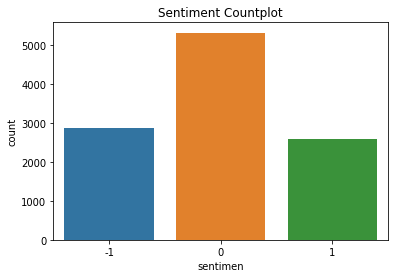

In [ ]:
sns.countplot(x='sentimen', data=df).set_title('Sentiment Countplot')

In [ ]:
neutral = df[df['sentimen'] == 0][0:2500]
negative = df[df['sentimen'] == -1][0:2500]
positive = df[df['sentimen'] == 1][0:2500]

df = pd.concat([neutral, negative, positive], axis=0)
df.reset_index(drop=True, inplace=True)
df

,sentimen,Tweet
0,0,barusan liat tulisan di belakang truk rela inj...
1,0,her itu lho miss kevin sama keven rebutan gimb...
2,0,iya rep gatau aku masih kelas 4 sd ehh di block
3,0,aku mohon tepatilah janjimu penantiancintaeps19
4,0,bukan beria nk kahwin sbb gatal celah kangkang...
...,...,...
7495,1,kelak kita akan saling meninggalkan untuk sebu...
7496,1,cinta batik cinta indonesia haribatiknasional
7497,1,lucu sekali sih kamu jadi pen gigit
7498,1,emng gemesin mereka


# **Preprocessing**

In [ ]:
emoji = {}
with open('/content/Drive/My Drive/Dataset/emoji.txt', encoding="utf8") as file:
    for line in file:
        k, v = line.strip().split(', ')
        emoji[k] = v

def is_emoji(s):
    return s in UNICODE_EMOJI

def replace_emoji(tweet):
    result = ' '
    for char in tweet:
        if is_emoji(char):
            result = result + ' ' + emoji.get(char, char)
        else:
            result += emoji.get(char, char)
    return result

In [ ]:
# get stopwords
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# initiate stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def data_cleaning(data): 

    cek = []
    for i, tweet in enumerate (data['Tweet']):
        tweet = tweet.lower()
        
        # remove @username
        tweet = re.sub("(@[^\s]+|@[A-Za-z0-9]+)", " ", tweet)

        # replace emoji
        tweet = replace_emoji(str(tweet))        
        
        # stopword removal
        tweet = stopword.remove(tweet)
        tweet = re.sub("\d+", "", tweet)

        # stemming
        tweet = stemmer.stem(tweet)
        
        # remove duplicate char
        tweet = re.sub(r'(.)\1+$', r'\1', tweet)
        # tokenizing + append
        cek.append(tweet.strip())
        
        clear_output(wait=True)
        print("Progress ", str((i+1)/len(data['Tweet'])*100) + " %" )
    data['cleantweet'] = cek
    return data

In [ ]:
data = data_cleaning(df)
data

Progress  100.0 %


,sentimen,Tweet,cleantweet
0,0,barusan liat tulisan di belakang truk rela inj...,barusan liat tulis belakang truk rela injek ko...
1,0,her itu lho miss kevin sama keven rebutan gimb...,her lho miss kevin sama keven rebut gimbot wis...
2,0,iya rep gatau aku masih kelas 4 sd ehh di block,iya rep gatau aku kelas sd ehh block
3,0,aku mohon tepatilah janjimu penantiancintaeps19,aku mohon tepat janji penantiancintaeps
4,0,bukan beria nk kahwin sbb gatal celah kangkang...,bukan ria nk kahwin sbb gatal celah kangkang t...
...,...,...,...
7495,1,kelak kita akan saling meninggalkan untuk sebu...,kelak akan saling tinggal buah bahagia yang tu...
7496,1,cinta batik cinta indonesia haribatiknasional,cinta batik cinta indonesia haribatiknasional
7497,1,lucu sekali sih kamu jadi pen gigit,lucu sekali sih kamu jadi pen gigit
7498,1,emng gemesin mereka,emng gemesin


In [ ]:
data.to_csv("clean data.csv", index=False)

# **Read Data**

In [ ]:
df = pd.read_csv("/content/Drive/My Drive/Dataset/clean data.csv")
df.head()

,sentimen,Tweet,cleantweet
0,0,barusan liat tulisan di belakang truk rela inj...,barusan liat tulis belakang truk rela injek ko...
1,0,her itu lho miss kevin sama keven rebutan gimb...,her lho miss kevin sama keven rebut gimbot wis...
2,0,iya rep gatau aku masih kelas 4 sd ehh di block,iya rep gatau aku kelas sd ehh block
3,0,aku mohon tepatilah janjimu penantiancintaeps19,aku mohon tepat janji penantiancintaeps
4,0,bukan beria nk kahwin sbb gatal celah kangkang...,bukan ria nk kahwin sbb gatal celah kangkang t...


In [ ]:
encoder = pd.get_dummies(df["sentimen"])
data = pd.concat([df['cleantweet'], encoder], axis=1)
data.columns = ['Tweet','Negatif', 'Netral', 'Positif']
data.head()

,Tweet,Negatif,Netral,Positif
0,barusan liat tulis belakang truk rela injek ko...,0,1,0
1,her lho miss kevin sama keven rebut gimbot wis...,0,1,0
2,iya rep gatau aku kelas sd ehh block,0,1,0
3,aku mohon tepat janji penantiancintaeps,0,1,0
4,bukan ria nk kahwin sbb gatal celah kangkang t...,0,1,0


# **Train Test Split**

In [ ]:
X = data['Tweet']
y = data.drop('Tweet', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=123)

### **Vectorizer**

In [ ]:
#Count Vectorization
countvectorizer = CountVectorizer()
X_train = countvectorizer.fit_transform(X_train.astype('U'))
X_test = countvectorizer.transform(X_test)

In [ ]:
#TF-IDF Vectorization

tfidftransformer = TfidfTransformer()
X_train = tfidftransformer.fit_transform(X_train).toarray()
X_test = tfidftransformer.transform(X_test).toarray()

# **Model**

In [ ]:
model = Sequential()

model.add(Dense(units=2500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1000,activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(units=250,activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
model.fit(x = X_train, y = y_train, batch_size = 64, epochs = 20, validation_data = (X_test, y_test), verbose = 1, callbacks=early_stop)

Epoch 1/20
77/77 [==============================] - 3s 41ms/step - loss: 0.0363 - accuracy: 0.9819 - val_loss: 1.8858 - val_accuracy: 0.5798
Epoch 2/20
77/77 [==============================] - 3s 40ms/step - loss: 0.0315 - accuracy: 0.9828 - val_loss: 1.9637 - val_accuracy: 0.5790
Epoch 3/20
77/77 [==============================] - 3s 40ms/step - loss: 0.0325 - accuracy: 0.9822 - val_loss: 1.9966 - val_accuracy: 0.5798
Epoch 00003: early stopping


In [ ]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', score[1])

42/42 [==============================] - 0s 11ms/step - loss: 1.2189 - accuracy: 0.6000
Test accuracy: 0.6000000238418579
